In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 12.2MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621010 sha256=666d0afe9b2b90dbd23e451d62a940bd0152f8bd04fb7a0450051d711f8a65d4
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=7ef1290abb393be181c8d79e94902e34f1a7b47660b4650a6de14c8dd5fc7b76
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [2]:
import pycuda.autoinit
from pycuda.tools import make_default_context
make_default_context().get_device().name()

'Tesla T4'

In [3]:
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit

In [4]:
kernel_code_template = """ 
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void interpolate(unsigned int * __restrict__ d_result, const int M, const int N, const float sigma_d, const float sigma_r)
{
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;


    if ((i<M)&&(j<N)) {
        float s = 0;
        float c = 0;
        for (int l = i-1; l <= i+1; l++){
            for (int k = j-1; k <= j+1; k++){
                float img1 = tex2D(tex, k, l)/255;
                float img2 = tex2D(tex, i, j)/255;
                float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                float r = exp(-pow((img1 - img2)*255, 2) / pow(sigma_r, 2));
                c += g*r;
                s += g*r*tex2D(tex, k, l);
            }
        }
        d_result[i*N + j] = s / c;
    }
}"""


In [5]:
import numpy as np
import cv2
import timeit
from google.colab.patches import cv2_imshow

In [6]:
def bil_pixel(image, i, j, sigma_d, sigma_r):
    c = 0
    s = 0
    for k in range(i - 1, i + 2):
        for l in range(j - 1, j + 2):
            g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            i1 = image[k, l] / 255
            i2 = image[i, j] / 255
            r = np.exp(-((i1 - i2) * 255) ** 2 / sigma_r ** 2)
            c += g * r
            s += g * r * image[k, l]
    result = s / c
    return result


def bilateral(image, sigma_d, sigma_r):
    n_image = np.zeros(image.shape)
    w = image.shape[0]
    h = image.shape[1]
    for i in range(1, w - 1):
        for j in range(1, h - 1):
            n_image[i, j] = bil_pixel(image, i, j, sigma_d, sigma_r)
    return n_image

In [40]:
image = cv2.imread('/content/input.bmp', cv2.IMREAD_GRAYSCALE)
M, N = image.shape
sigma_d = 200
sigma_r = 2
gpu_result = np.zeros((M, N), dtype=np.uint32)
block = (32, 32, 1)
grid = (int(np.ceil(M / block[0])), int(np.ceil(N / block[1])))

mod = compiler.SourceModule(kernel_code_template)
bilateral_kernel = mod.get_function("interpolate")
start = driver.Event()
stop = driver.Event()

print("Reading GPU..")
start.record()

tex = mod.get_texref("tex")
tex.set_filter_mode(driver.filter_mode.LINEAR)
tex.set_address_mode(0, driver.address_mode.MIRROR)
tex.set_address_mode(1, driver.address_mode.MIRROR)
driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

bilateral_kernel(driver.Out(gpu_result), np.int32(M), np.int32(N), np.float32(sigma_d), np.float32(sigma_r),
                 block=block, grid=grid, texrefs=[tex])
driver.Context.synchronize()
stop.record()
stop.synchronize()
gpu_time = stop.time_since(start)
print("GPU calculation time %.3f ms" % (gpu_time))
cv2.imwrite('res_gpu.bmp', gpu_result.astype(np.uint8))

print("Reading CPU...")
start.record()
cpu_result = bilateral(image, sigma_d, sigma_r)
stop.record()
stop.synchronize()
cpu_time = stop.time_since(start)
print("CPU calculation time %.3f ms" % (cpu_time))

cv2.imwrite('res_cpu.bmp', cpu_result)


Reading GPU..
GPU calculation time 79.518 ms
Reading CPU...
CPU calculation time 106258.602 ms


True

Исходное изображение


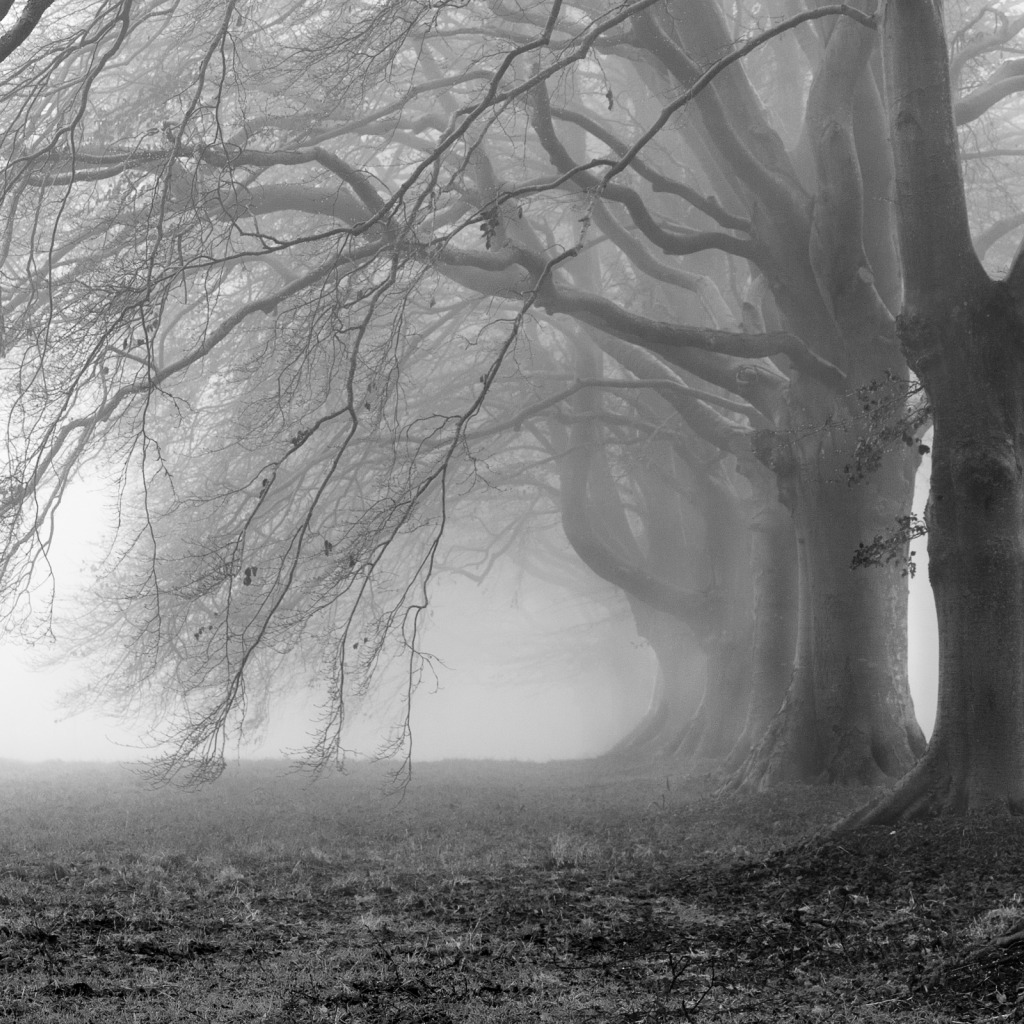

In [41]:
image = cv2_imshow(image)

Изображение с СPU

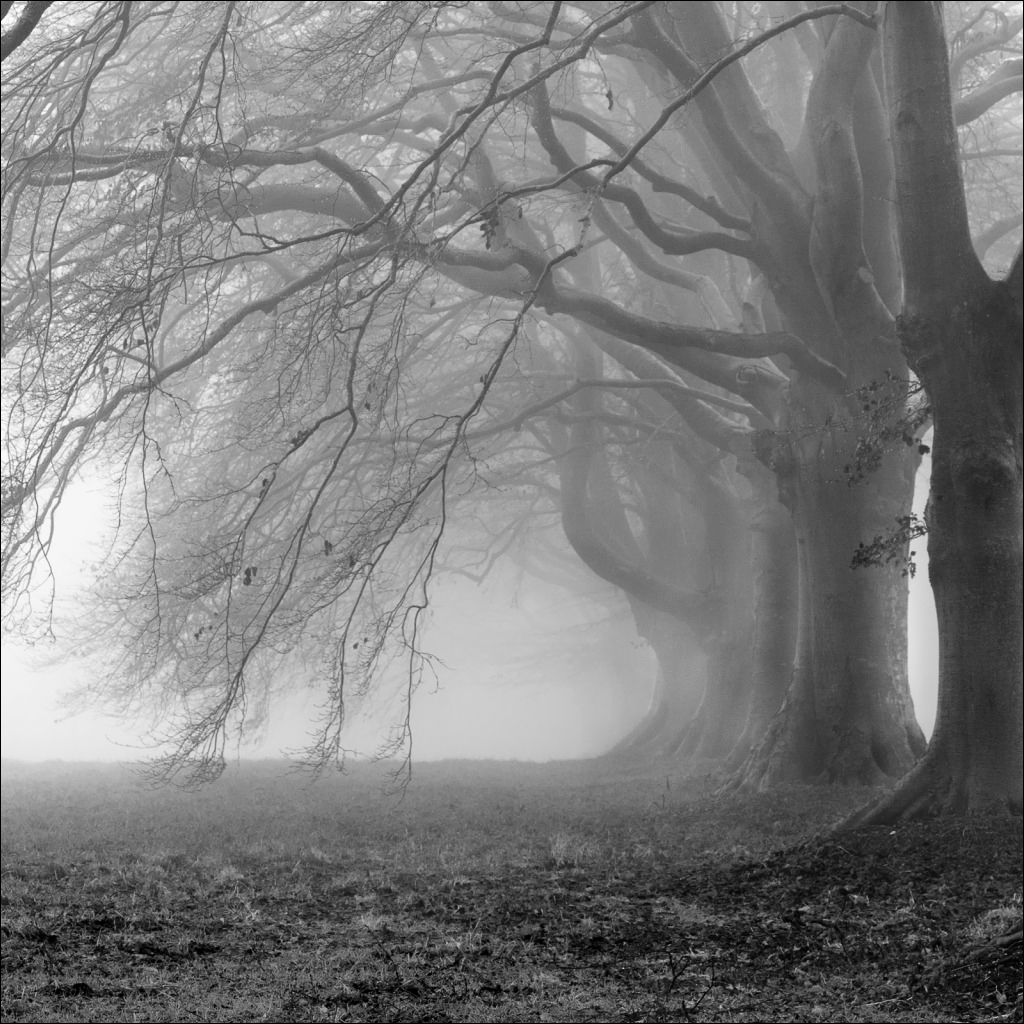

In [42]:
image = cv2_imshow(cpu_result)

Изображение с GPU

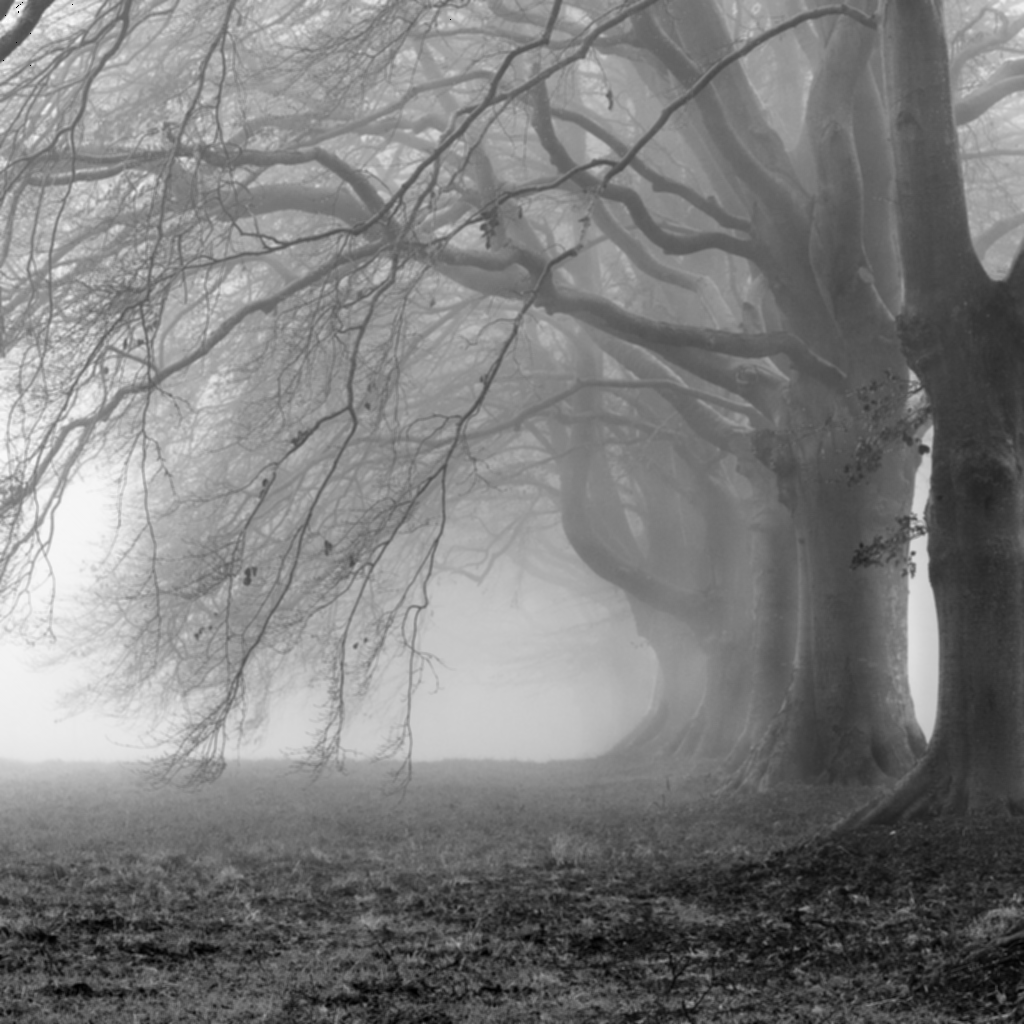

In [43]:
cv2_imshow(gpu_result)